# Examples of usage

Spatial weights are used across `momepy`. This notebook will illustrate its use on three examples.

In [1]:
import matplotlib.pyplot as plt
import momepy

We will again use `osmnx` to get the data for our example and after preprocessing of building layer will generate tessellation layer.

In [2]:
import osmnx as ox

gdf = ox.geometries.geometries_from_place(
    "Kahla, Germany", tags={"building": True}
)
buildings = ox.projection.project_gdf(gdf)

buildings["uID"] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tessellation = momepy.Tessellation(
    buildings, unique_id="uID", limit=limit
).tessellation

Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


/Users/martin/Git/geopandas/geopandas/geoseries.py:190: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)


## First order contiguity

### Distance to neighbours

To calculate the mean distance to neighbouring buildings, we need queen contiguity weights of the first order capturing the relationship between immediate neighbours. Relationship between buildings is here represented by relationships between their tessellation cells.

In [3]:
sw1 = momepy.sw_high(k=1, gdf=tessellation, ids="uID")

In [4]:
buildings["neighbour_dist"] = momepy.NeighborDistance(
    buildings, sw1, "uID"
).series

  0%|          | 0/2947 [00:00<?, ?it/s]

/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.distance(a, b, **kwargs)
/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pygeos/measurement.py:70: RuntimeWarning: overflow encountered in distance
  return lib.dista

**Note:** If there is no neighbour for a building denoted in `spatial_weights`, the value is set to `np.nan`. In GeoPandas older than 0.7.0, rows with NaN have to be removed before plotting with natural breaks scheme.

In [5]:
buildings = buildings.dropna(subset=["neighbour_dist"])

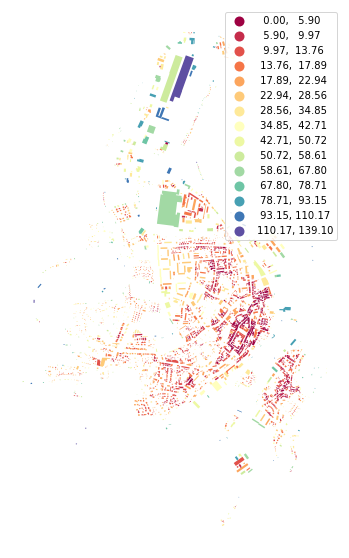

In [6]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(
    ax=ax,
    column="neighbour_dist",
    scheme="naturalbreaks",
    k=15,
    legend=True,
    cmap="Spectral",
)
ax.set_axis_off()
plt.show()

## Higher order / distance

However, typical usage of spatial weights is to capture the vicinity of each feature. As illustrated in the [previous notebook](weights_nb.ipynb), there are multiple options on how to capture it. In this example, we will use queen contiguity of the higher order (3) based on morphological tessellation.

In [7]:
sw3 = momepy.sw_high(k=3, gdf=tessellation, ids="uID")

### Average character

Mean value of selected character within a vicinity of each cell (or building, plot) is a simple example. `AverageCharacter` can measure mean, median or mode and defaults to `all`. Each of them can be accessed using `.mean`, `.median` or `.mode`. `.series` will return mean.

In [8]:
areas = momepy.Area(tessellation).series
mean_area = momepy.AverageCharacter(
    tessellation, values=areas, spatial_weights=sw3, unique_id="uID"
)
tessellation["mean_area"] = mean_area.mean

  0%|          | 0/2947 [00:00<?, ?it/s]

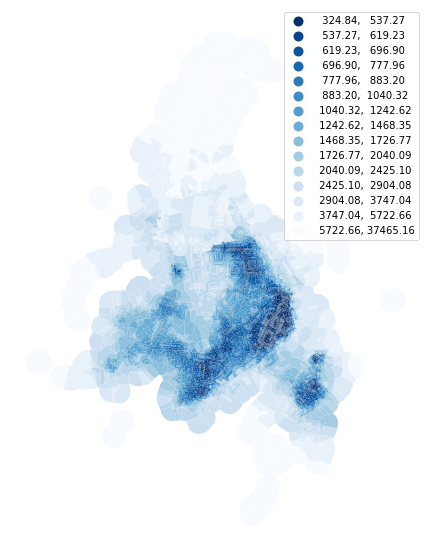

In [9]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(
    ax=ax,
    column="mean_area",
    legend=True,
    scheme="quantiles",
    k=15,
    cmap="Blues_r",
)
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

In some cases, we might want to eliminate the effect of outliers. To do so, we can specify the range on which should `AverageCharacter` calculate mean. Below we will measure only interquartile mean.

In [10]:
tessellation["mean_area_iq"] = momepy.AverageCharacter(
    tessellation, areas, sw3, "uID", rng=(25, 75)
).mean

  0%|          | 0/2947 [00:00<?, ?it/s]

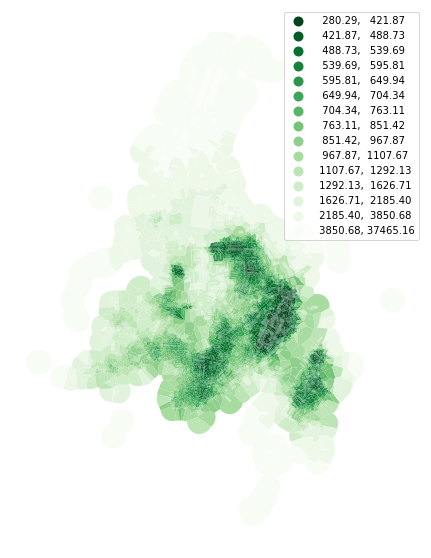

In [11]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(
    ax=ax,
    column="mean_area_iq",
    legend=True,
    scheme="quantiles",
    k=15,
    cmap="Greens_r",
)
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

Another option would be to calculate median only:

In [12]:
tessellation["med_area"] = momepy.AverageCharacter(
    tessellation, areas, sw3, "uID", mode="median"
).median

  0%|          | 0/2947 [00:00<?, ?it/s]

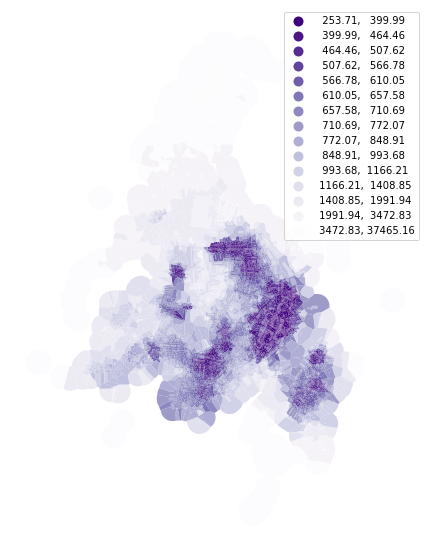

In [13]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(
    ax=ax,
    column="med_area",
    legend=True,
    scheme="quantiles",
    k=15,
    cmap="Purples_r",
)
buildings.plot(ax=ax, color="white", alpha=0.4)
ax.set_axis_off()
plt.show()

### Weighted character

The weighted average is another example using the same spatial weights. For illustration, we can try area-weighted circular compactness:

In [14]:
circular_compactness = momepy.CircularCompactness(buildings)
buildings["weighted_circom"] = momepy.WeightedCharacter(
    buildings,
    circular_compactness.series,
    sw3,
    "uID",
    momepy.Area(buildings).series,
).series

  0%|          | 0/2944 [00:00<?, ?it/s]

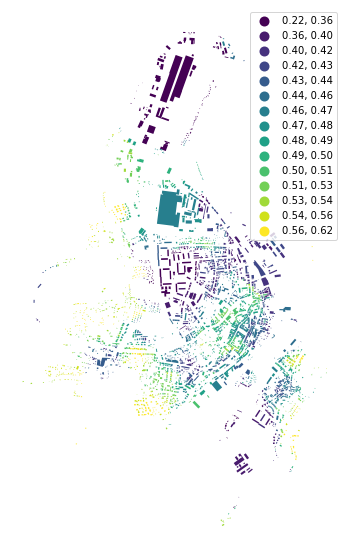

In [15]:
f, ax = plt.subplots(figsize=(10, 10))
buildings.plot(
    ax=ax,
    column="weighted_circom",
    legend=True,
    scheme="quantiles",
    k=15,
    cmap="viridis",
)
ax.set_axis_off()
plt.show()

### Density

We will again use our Manhattan case study to illustrate `Density`.

In [16]:
point = (40.731603, -73.977857)
dist = 1000
gdf = ox.geometries.geometries_from_point(
    point, dist=dist, tags={"building": True}
)
gdf_projected = ox.projection.project_gdf(gdf)
buildings = gdf_projected[
    gdf_projected.geom_type.isin(["Polygon", "MultiPolygon"])
]

buildings["uID"] = momepy.unique_id(buildings)
limit = momepy.buffered_limit(buildings)
tessellation = momepy.Tessellation(
    buildings, unique_id="uID", limit=limit
).tessellation

/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Inward offset...
Generating input point array...
Generating Voronoi diagram...
Generating GeoDataFrame...
Dissolving Voronoi polygons...


/Users/martin/Git/geopandas/geopandas/geoseries.py:190: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  s = pd.Series(data, index=index, name=name, **kwargs)
/Users/martin/Git/momepy/momepy/elements.py:386: UserWarning: Tessellation contains MultiPolygon elements. Initial objects should be edited. unique_id of affected elements: [217, 405, 833, 835, 1994, 3053, 3056, 3070, 3136, 3147, 3157, 3163]
  warnings.warn(


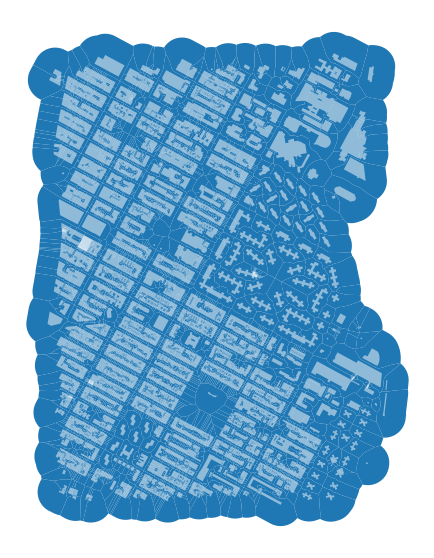

In [17]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax)
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()
plt.show()

To get gross density, we need to know floor areas:

In [18]:
def clean_heights(x):
    try:
        return float(x)
    except ValueError:
        return 0


buildings["height"] = buildings["height"].fillna(0).apply(clean_heights)

buildings["floor_area"] = momepy.FloorArea(buildings, "height").series

/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


Now we merge floor areas to tessellation based on shared unique ID and generate spatial weights.

In [19]:
tessellation = tessellation.merge(buildings[["uID", "floor_area"]])
sw = momepy.sw_high(k=3, gdf=tessellation, ids="uID")

`Density` is then following the same principle as illustrated above.

In [20]:
gross = momepy.Density(
    tessellation, values="floor_area", spatial_weights=sw, unique_id="uID"
)
tessellation["gross_density"] = gross.series

  0%|          | 0/3192 [00:00<?, ?it/s]

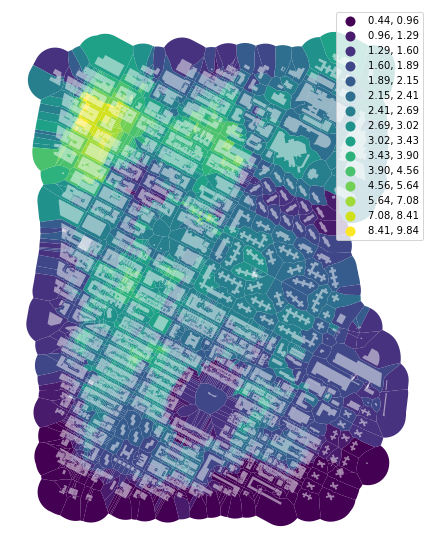

In [21]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(
    ax=ax, column="gross_density", legend=True, scheme="naturalbreaks", k=15
)
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()
plt.show()

In a similar way can be done gross coverage.

In [22]:
buildings["area"] = momepy.Area(buildings).series
tessellation = tessellation.merge(buildings[["uID", "area"]])

/opt/miniconda3/envs/geo_dev/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


In [23]:
coverage = momepy.Density(
    tessellation, values="area", spatial_weights=sw, unique_id="uID"
)
tessellation["gross_coverage"] = coverage.series

  0%|          | 0/3192 [00:00<?, ?it/s]

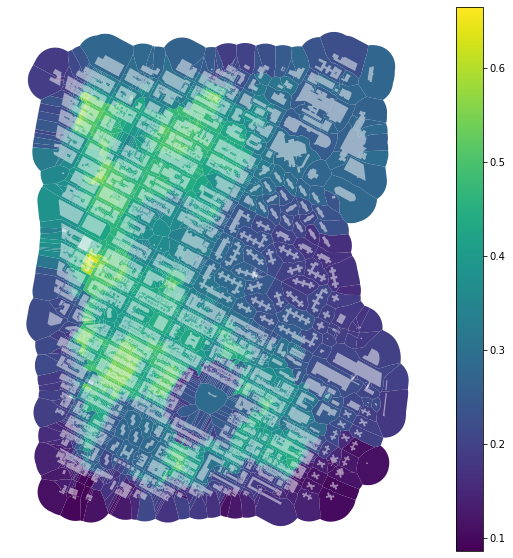

In [24]:
f, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, column="gross_coverage", legend=True)
buildings.plot(ax=ax, color="white", alpha=0.5)
ax.set_axis_off()
plt.show()